In [2]:
##THIS SCRIPT NEVER ACTUALLY WORKED. CHOSE TO DO IT IN R INSTEAD: getPhyDists.R

In [1]:
import pandas as pd

from pandas import DataFrame as df
import numpy as np
import csv
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity 
import pickle
import keras
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Embedding, Reshape, Dot
from keras.models import Model 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import linregress

C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
otu = pd.read_csv("data/silva/test_out.csv", sep = "\t", index_col=0)
otu.shape

(5, 4)

In [2]:
phy_dists = pd.read_csv("data/silva/tree/phy_dists.txt", sep = " ", index_col=0)

In [3]:
print(phy_dists.head())
print(phy_dists.shape)


          AJ583198  HM839387  HM328916  AB630814  JF920373  JX505373  \
AJ583198   0.00000   0.11643   0.36387   0.42481   0.15602   0.14740   
HM839387   0.11643   0.00000   0.35908   0.42002   0.15123   0.14261   
HM328916   0.36387   0.35908   0.00000   0.27810   0.32633   0.32909   
AB630814   0.42481   0.42002   0.27810   0.00000   0.38727   0.39003   
JF920373   0.15602   0.15123   0.32633   0.38727   0.00000   0.12124   

          EU472027  JX542560  EU469099  EU778783    ...     GQ451299  \
AJ583198   0.14692   0.14161   0.13383   0.15216    ...      0.35210   
HM839387   0.14213   0.13682   0.12904   0.14737    ...      0.34731   
HM328916   0.34937   0.34406   0.33628   0.35461    ...      0.56179   
AB630814   0.41031   0.40500   0.39722   0.41555    ...      0.62273   
JF920373   0.14152   0.13621   0.12843   0.14676    ...      0.35394   

          DQ456357  HQ681868  EF559115  KF931641  JN899152  JNLE01000003  \
AJ583198   0.35605   0.28993   0.21571   0.22483   0.20872

In [4]:
dict_file = open("dictionary.obj", "rb")
dictionary = pickle.load(dict_file)

revdict_file = open("reverse_dictionary.obj", "rb")
reverse_dictionary = pickle.load(revdict_file)

vocab_size = len(dictionary)
#Dictionary goes [taxa: int_id]
#Reverse dictionary goes [int_id: taxa]

In [5]:
id_1 = "AY725249"
id_2 = "EF464627"
print(id_1)
print(id_2)
def getPhyDist(id_1, id_2):
    return(phy_dists[id_1][id_2])

AY725249
EF464627


vector_dim = 500

input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name = "embedding")
target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)

context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

similarity = Dot(axes = 0, normalize = True)([target, context]) # cosine similarity (end up with scalar)

validation_model = Model(inputs=[input_target, input_context], outputs = similarity)


dot_product = Dot(axes = 1, normalize = False)([target, context]) #Component-wise multiply
dot_product = Reshape((1,))(dot_product)

output = Dense(1, activation='sigmoid')(dot_product)

model = Model(inputs=[input_target, input_context], outputs = output)
model.compile(loss = "binary_crossentropy", optimizer = 'rmsprop')


print(validation_model.weights)
#Load Weights
validation_model.load_weights("word2vec_weights/epoch8250000-loss0.0345.h5", by_name = True)
model.load_weights("word2vec_weights/epoch8250000-loss0.0345.h5")

def getCosineDist(id_1, id_2):
    in_arr1 = np.zeros((1,))
    in_arr2 = np.zeros((1,))
    in_arr1[0,] = dictionary[id_1]
    in_arr2[0,] = dictionary[id_2]
    cosine_sim = validation_model.predict([in_arr1, in_arr2])
    return(1 - cosine_sim[0][0][0])

In [6]:
def getModelPrediction(id_1, id_2):
    in_arr1 = np.zeros((1,))
    in_arr2 = np.zeros((1,))
    in_arr1[0,] = id_1
    in_arr2[0,] = id_2
    context = model.predict([in_arr1, in_arr2])
    return(context)

In [ ]:
#Grab some positive examples
pos_file = open("contexts/pos/couples_22.obj", "rb")
pos_exs = pickle.load(pos_file)

In [ ]:

#Grab some negative examples
neg_file = open("contexts/neg/couples_0.obj", "rb")
neg_exs = pickle.load(neg_file)
#Check out model accuracy

In [18]:
print(pos_exs[1:5])
print(neg_exs[1:5])
print("Positive examples")
for i in range(10):
    context = getModelPrediction(pos_exs[i][0], pos_exs[i][1])
    print(context)
    
print("Negative examples")
for i in range(10):
    context = getModelPrediction(neg_exs[i][0], neg_exs[i][1])
    print(context)

[[266, 782], [266, 333], [266, 77], [266, 71]]
[[6, 16304], [6, 18183], [6, 17095], [6, 14574]]
Positive examples
[[0.9743455]]
[[0.9624177]]
[[0.97451425]]
[[0.9613722]]
[[0.9603448]]
[[0.9657269]]
[[0.94418865]]
[[0.97918314]]
[[0.95902884]]
[[0.9606839]]
Negative examples
[[0.9995346]]
[[0.9997274]]
[[0.99943656]]
[[0.9996525]]
[[0.9997501]]
[[0.9995635]]
[[0.9996325]]
[[0.9993924]]
[[0.99968565]]
[[0.9996995]]


In [13]:
taxa = list(dictionary.keys())[1:]
taxa

['HQ003607',
 'HQ178706',
 'JQ801240',
 'JN392909',
 'FJ820442',
 'EU133115',
 'DQ444448',
 'AB754051',
 'EF019356',
 'FQ658607',
 'EF516775',
 'FJ946602',
 'JX223915',
 'LN566438',
 'EF516490',
 'FJ479002',
 'HQ225017',
 'AB753870',
 'KC358110',
 'JQ977271',
 'AJ616274',
 'KJ782783',
 'KC253294',
 'KF463403',
 'JN461946',
 'EF434357',
 'EU431767',
 'ADGO01079279',
 'JN391797',
 'JX223522',
 'KM221308',
 'JN672397',
 'KM016284',
 'GQ009814',
 'DQ676399',
 'GU437451',
 'EF020231',
 'KF512522',
 'HG528976',
 'GU127501',
 'AB746810',
 'FJ381973',
 'KC331500',
 'KC683170',
 'EU134162',
 'AB540020',
 'KF083040',
 'EF520436',
 'JF429089',
 'HM270210',
 'EF111072',
 'AB753963',
 'EU202847',
 'KC620942',
 'HM845855',
 'AM749762',
 'EU475472',
 'FQ659465',
 'HQ588428',
 'KP170490',
 'FJ478717',
 'FN421971',
 'KJ568443',
 'AY741401',
 'EU536661',
 'EU135499',
 'EU335224',
 'KJ123795',
 'EF018465',
 'FN668275',
 'DQ676288',
 'AB630640',
 'GQ480054',
 'FJ822619',
 'HM302618',
 'FJ802302',
 'AF3316

In [27]:
phy_dist_list = list()
cosine_dist_list = list()
taxa_use = taxa[1:10000]
for id_1 in taxa_use:
    for id_2 in taxa_use:
        if id_1 != id_2 :
            phy_dist = getPhyDist(id_1, id_2)
            cosine_dist = getCosineDist(id_1, id_2)
            phy_dist_list.append(phy_dist)
            cosine_dist_list.append(cosine_dist)
        

Is there any correlation between phylogenetic distance and cosine dissimilarity between quality vectors

In [25]:
np.array(phy_dist_list) * slope

array([21.41802799, 23.04487962,  8.79286504, ..., 17.2186377 ,
       15.75701621, 22.87887828])

-219.40368443029536
6.77724607352143
(0.005050668258348057, 4.5800789575687815e-07)


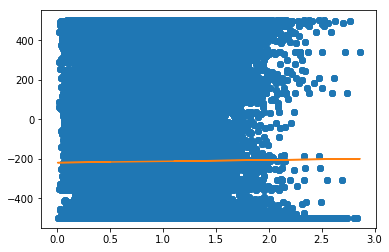

In [28]:
plt.scatter(phy_dist_list, cosine_dist_list)
slope, intercept, r_value, p_value, std_err = linregress(phy_dist_list, cosine_dist_list)
print(intercept)
print(slope)

line = slope* np.array(phy_dist_list) + intercept
plt.plot(phy_dist_list, cosine_dist_list,'o', phy_dist_list, line)
print(pearsonr(phy_dist_list, cosine_dist_list))

In [27]:
import time
start = time.time()
phy_dists_small = tree_small.phylogenetic_distance_matrix()
end = time.time()
print(end - start)

208.07841777801514


In [9]:
#phy_dists_tab = phy_dists.as_data_table()

In [10]:
share_sample_counts = t

In [16]:
cosine_similarity(np.array([1,2,3]).reshape(-1,1), np.array([1,2,3]).reshape(-1,1))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [26]:
from numpy.linalg import norm
pca_comp = pickle.load(open("pca_components.obj", "rb"))
taxa = pickle.load(open("taxa.obj", "rb"))

phy_dist_list = list()
pca_dist_list = list()
taxa_use = taxa[0:200]
for i in range(len(taxa_use)):
    for j in range(len(taxa_use)):
        phy_dist = getPhyDist(taxa[i], taxa[j])
        pca_dist = 1 - np.dot(pca_comp[i,:], pca_comp[j,:])/(norm((pca_comp[i,:])*norm(pca_comp[j,:])))
        
        phy_dist_list.append(phy_dist)
        pca_dist_list.append(pca_dist)
        

(0.08004054378520954, 7.475931418803082e-58)


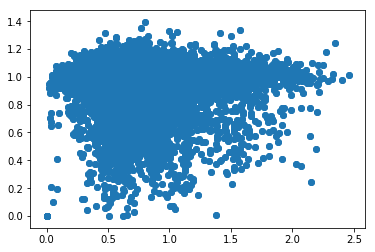

In [28]:

plt.scatter(phy_dist_list, pca_dist_list)
print(pearsonr(phy_dist_list, pca_dist_list))

In [3]:
qual_vecs = pd.read_csv("embeddings/silva/glove_emb_freshwater_2perc_500.txt", sep = " ", index_col = 0, header=None)
qual_vecs = qual_vecs.drop("<unk>", axis = 0)
qual_vecs.head()

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,,,,,,,,,,,,,,,,,,,,,
EF111171,0.120558,0.344913,0.065359,0.164604,0.022335,-0.010506,0.215318,-0.398671,-0.055348,0.090604,...,0.135781,-0.064413,-0.034190,-0.122950,0.247035,-0.092621,-0.236262,-0.082161,-0.089951,0.004798
GU127198,0.052221,0.552655,0.006732,0.067078,0.247296,0.365529,-0.070627,-0.283178,-0.079033,0.300026,...,-0.120189,0.061027,-0.304076,0.269277,0.053615,0.089568,-0.205022,-0.240862,-0.037295,0.188797
GQ388775,-0.281597,0.364923,-0.083480,-0.009604,-0.127312,-0.192143,0.219929,0.042317,-0.167354,0.328284,...,0.075366,0.267785,0.011325,-0.047053,0.108474,-0.132507,-0.389616,0.124557,-0.119673,-0.125174
HM346776,-0.097267,0.125345,-0.163497,0.419889,-0.099444,0.082789,0.227000,0.057113,-0.282058,0.001284,...,-0.061076,0.018308,-0.165371,0.014313,-0.035307,0.093557,-0.552330,0.219922,-0.146428,0.281244
EU800295,0.232074,0.197474,-0.131251,0.240901,0.219368,0.400498,0.257570,-0.104864,-0.204351,-0.068343,...,-0.037122,-0.236228,-0.252097,0.026793,0.052869,-0.040219,-0.123651,0.148660,0.188558,0.477138


In [43]:
phy_dist_list = list()
qual_vec_list = list()
taxa_pair_list = list()
for i in range(len(taxa_use)):
    print(i, end = "")
    for j in range(len(taxa_use)):
        phy_dist = getPhyDist(taxa[i], taxa[j])
        qualvec_dist = 1 - np.dot(qual_vecs.iloc[i,:], qual_vecs.iloc[j,:])/(norm((qual_vecs.iloc[i,:])*norm(qual_vecs.iloc[j,:])))
        phy_dist_list.append(phy_dist)
        qual_vec_list.append(qualvec_dist)
        taxa_pair_list.append((taxa[i], taxa[j]))
        

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199

(0.0608292020243808, 4.134988632200334e-34)


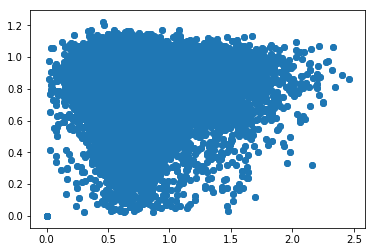

In [36]:
plt.scatter(phy_dist_list, qual_vec_list)
print(pearsonr(phy_dist_list, qual_vec_list))

In [4]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(phy_dist_list,qual_vec_list)
x = phy_dist_list
slope = 0.7
intercept = 0.2
y = [slope * i + intercept for i in x]
plt.scatter(phy_dist_list, qual_vec_list)
plt.plot(x, y, color = "red")

keep = [qual_vec_list[i] > y[i] for i in range(len(x))]


for pair in np.array(taxa_pair_list)[keep]:
    taxa_keep.add(pair[0])
    taxa_keep.add(pair[1])
print("Number of taxa: " + str(len(taxa_keep)))
pickle.dump(taxa_keep, open("taxa_lowphy_highcos.obj", "wb"))

NameError: name 'phy_dist_list' is not defined

In [73]:
low_phy_dist = [i < 1 for i in phy_dist_list]
high_cos_dist = [i > 0.6 for i in qual_vec_list]
bools = [x & y for x,y in zip(low_phy_dist, high_cos_dist)]

taxa_keep = set()

for pair in np.array(taxa_pair_list)[bools]:
    taxa_keep.add(pair[0])
    taxa_keep.add(pair[1])

In [76]:
len(taxa_keep)
pickle.dump(taxa_keep, open("taxa_lowphy_highcos.obj", "wb"))

In [5]:
otu = pickle.load(open("otu_train.obj", "rb"))
otu.shape


(3367, 17000)

In [164]:
from sklearn.metrics import pairwise_distances
cosine_dists_otu = pairwise_distances(otu.T, metric="cosine")

In [165]:
cosine_dist_matrix = np.array([np.array(taxa_dists) for taxa_dists in cosine_dists_otu])

In [166]:
keep = [phy_dists.index.values[i] in taxa for i in range(phy_dists.shape[0])]
phy_dists_small = phy_dists.loc[keep, taxa]
print(phy_dists_small.shape)

(17000, 17000)


In [167]:
print(np.sum(otu.columns.values == phy_dists_small.columns.values))
phy_dists_small.sort_index(axis = 0)
phy_dists_small.index.values.sort()
print(np.sum(otu.columns.values == phy_dists_small.index.values))
#phy_dists_small.index.values == otu.columns.values

17000
17000


In [168]:
cosine_dist_matrix[0,0:5]

array([0.        , 0.99016127, 0.96005133, 0.97290806, 0.90869471])

In [235]:
#plt.scatter(phy_dists_small.tolist(), cosine_dist_matrix.tolist())
rand_row = np.random.choice(range(phy_dists_small.shape[0]), 1000)
phy = [i for sublist in phy_dists_small.iloc[rand_row, :].values for i in sublist]
cosine = [i for sublist in cosine_dist_matrix[rand_row, :] for i in sublist]
taxa = phy_dists_small.columns.values
taxa_pairs = [(taxa[i], taxa[j]) for i in rand_row for j in range(len(phy_dists_small.columns.values))]

len(phy)
len(cosine)
corr = pearsonr(phy, cosine)


#taxa_keep = set()
#for pair in np.array(taxa_pair_list)[keep]:
#    taxa_keep.add(pair[0])
#    taxa_keep.add(pair[1])
#print("Number of taxa: " + str(len(taxa_keep)))
#pickle.dump(taxa_keep, open("taxa_lowphy_highcos.obj", "wb"))

111155


In [237]:
slope = 5
intercept = 0.1
y = [slope * i + intercept for i in phy]
keep = [cosine[i] > y[i] for i in range(len(phy))]

print(np.sum(keep))

67391


In [240]:
taxa_keep = set()
for pair in np.array(taxa_pairs)[keep]:
    taxa_keep.add(pair[0])
    taxa_keep.add(pair[1])
print("Number of taxa: " + str(len(taxa_keep)))
pickle.dump(taxa_keep, open("taxa_lowphy_highcos.obj", "wb"))

Number of taxa: 11557


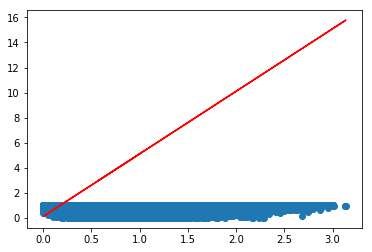

In [239]:
plt.scatter(phy, cosine)
plt.plot(phy, y, color = "red")

In [ ]:
#plt.scatter(phy_dists_small.tolist(), cosine_dist_matrix.tolist())
print(pearsonr(phy_dists_small.values.tolist()[0:5000], cosine_dist_matrix.tolist()[0:5000]))

#x = phy_dist_list
#slope = 1
#intercept = 0.1
#y = [slope * i + intercept for i in x]
#plt.scatter(phy_dist_list, otu_vec_list)
#plt.plot(x, y, color = "red")

#keep = [otu_vec_list[i] > y[i] for i in range(len(x))]

#taxa_keep = set()
#for pair in np.array(taxa_pair_list)[keep]:
#    taxa_keep.add(pair[0])
#    taxa_keep.add(pair[1])
#print("Number of taxa: " + str(len(taxa_keep)))
#pickle.dump(taxa_keep, open("taxa_lowphy_highcos.obj", "wb"))